# Code for Batch Trajectory Alignment and Similarity Metrics

In [1]:
# Set up:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from ipywidgets import *

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# import plotly.graph_objects as go
# import plotly.express as px
# import ipywidgets as widget

# Computation packages
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from fastdtw import fastdtw

In [2]:
from nah.loader import load_raw_csv_data, load_npzs
from nah.utils import norm_data, full_align,clean_rot_data, segment_by_demo, sum_of_squares, study_range_vals
from nah.plot import plot_norm, plot_pos, plot_rot, plot_raw_data, plot_heatmap, plot_correlation_matrix
from nah.datagraphs import generate_self_similarity_heat_map, hand_range, study_range_vals, generate_all_cross_correlation_matrix, generate_pairwise_comparison, generate_hand_endeff_similarity_matrix

from evo.core.trajectory import PoseTrajectory3D
from nah.trajectory import get_evo_trajectory, get_evo_metrics, evo_sync, convert_evo_to_np, evaluate_ape
from nah.alignments import evo_align, Alignment

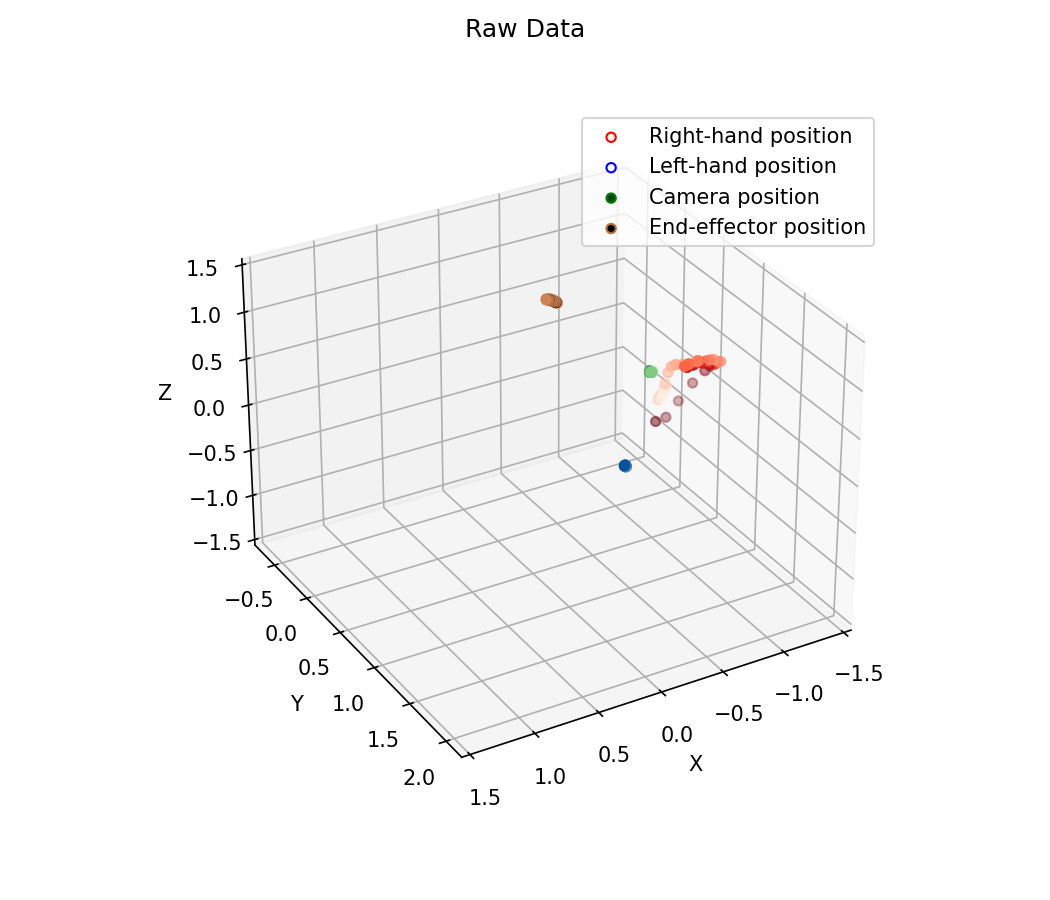

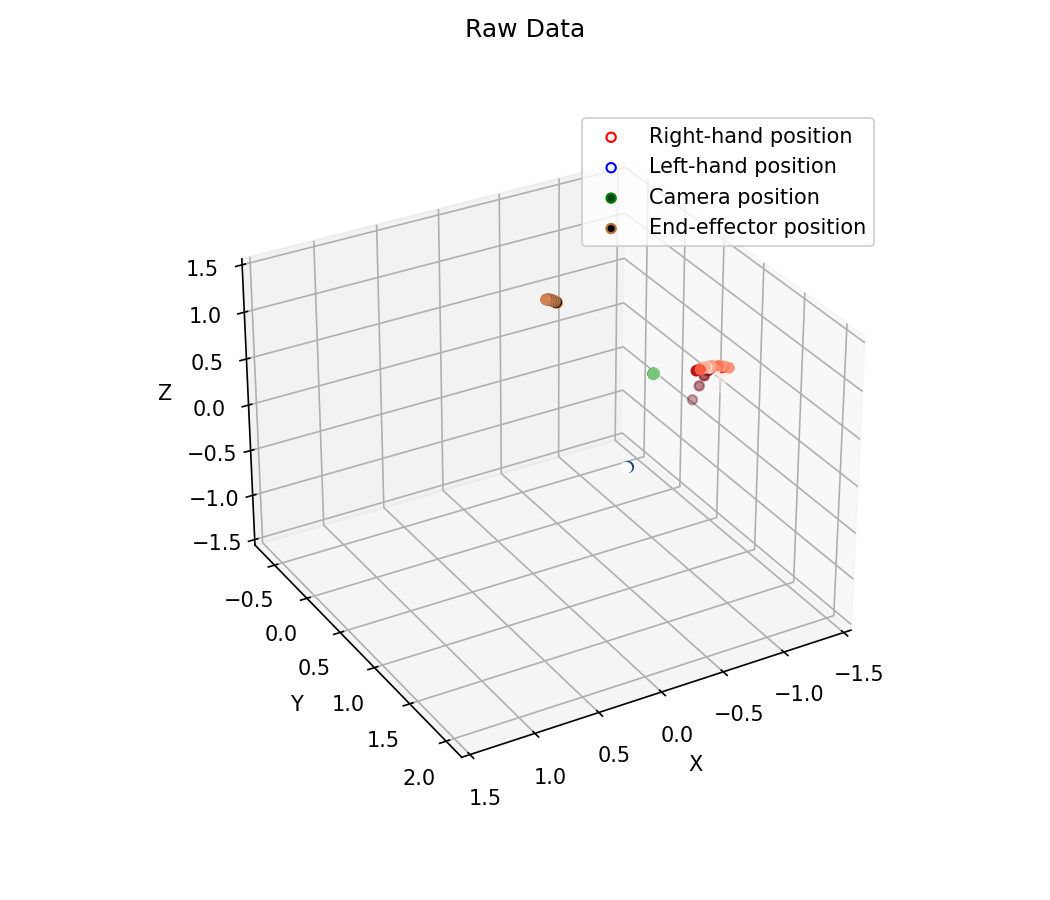

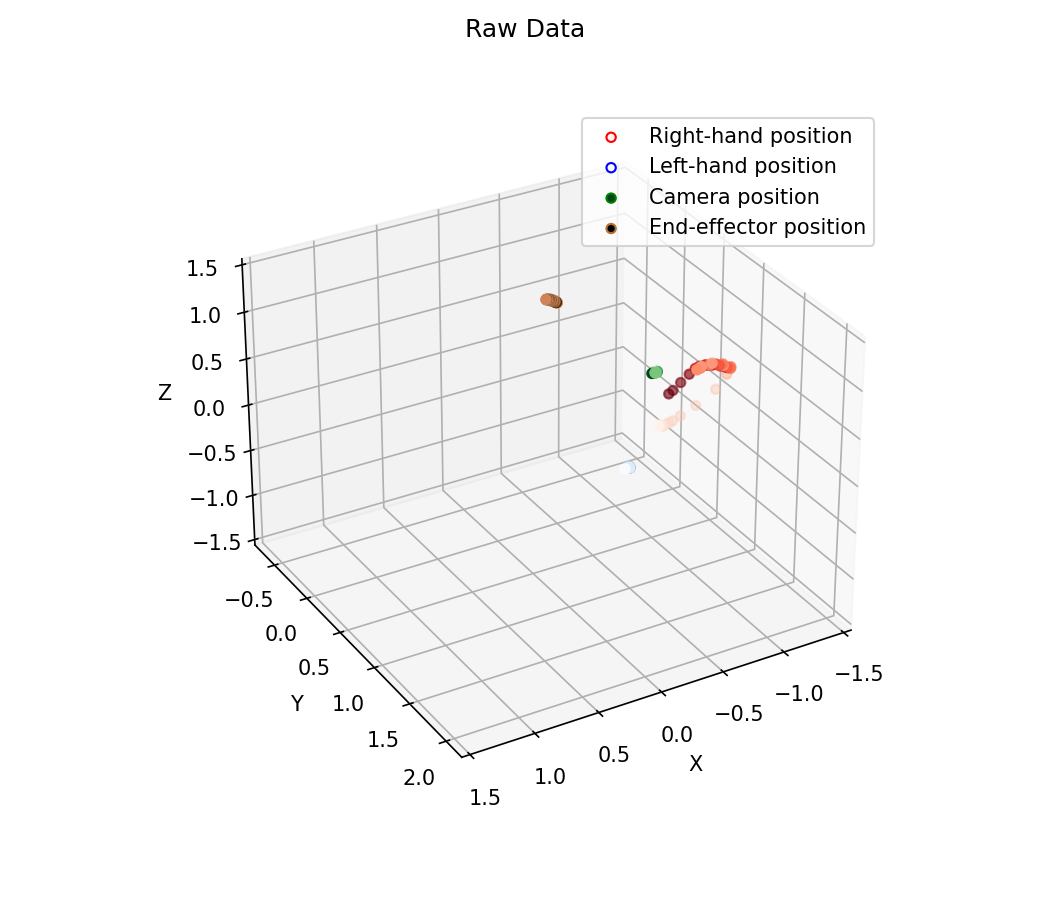

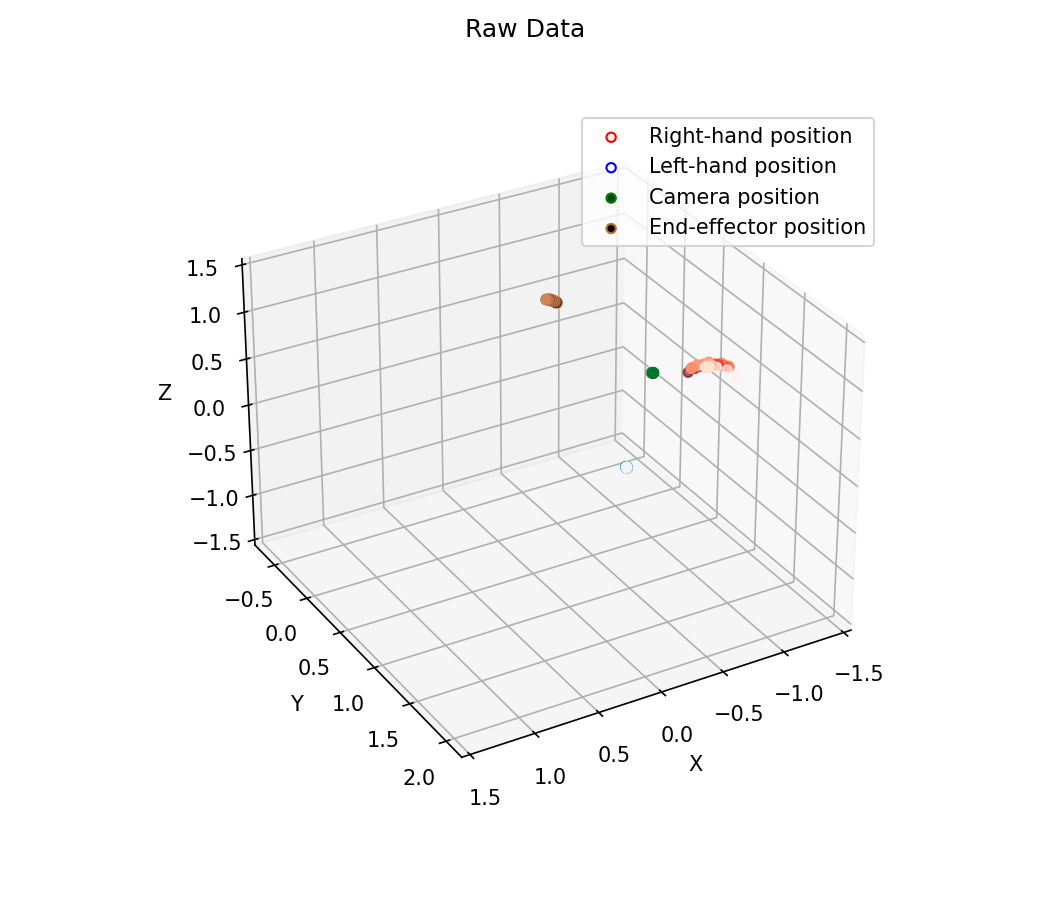

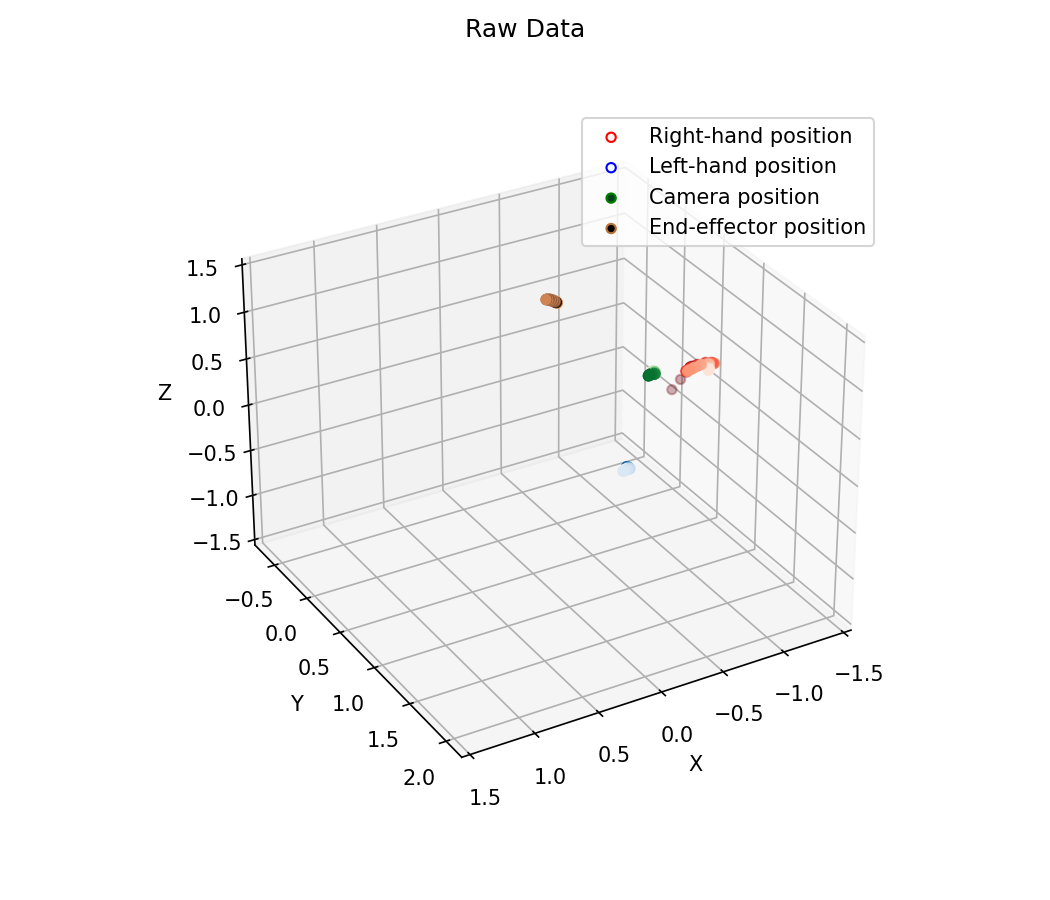

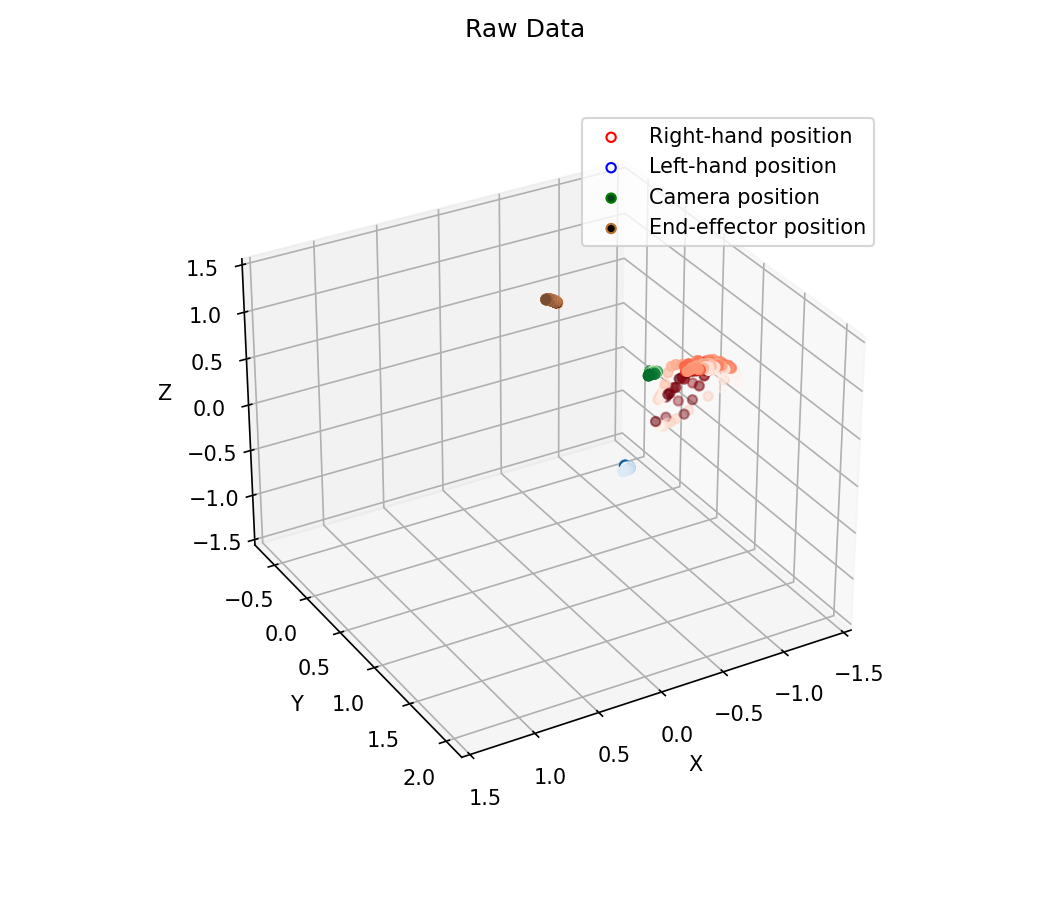

In [14]:
%matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

# robot_name='j2s6s300'
robot_name='Reachy'
gesture_num=1


total_end_eff = np.array([])
total_camera  = np.array([])
total_rh      = np.array([])
total_lh      = np.array([])
total_joint   = np.array([])

singlePID=True
singlePIDval = 7
followup = True

if singlePID:
    PID_begin_range=singlePIDval
    PID_end_range=singlePIDval+1 #Don't forget to +1 to whatever your last PID is
else:
    PID_begin_range=1
    if followup:
        PID_end_range=10 #Don't forget to +1 to whatever your last PID is
    else:
        PID_end_range=17
for PID in range(PID_begin_range,PID_end_range):
    end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)
    if (PID==PID_begin_range):
        total_end_eff = end_eff
        total_camera = camera
        total_rh = rh
        total_lh = lh
        total_joint = joint
    else:
        total_end_eff = np.vstack((total_end_eff,end_eff))
        total_camera  = np.vstack((total_camera,camera))
        total_rh      = np.vstack((total_rh,rh))
        total_lh      = np.vstack((total_lh,lh))
        total_joint   = np.vstack((total_joint,joint))

# plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

demo_max=5
end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
for i in range(0,5):
    plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

Right hand range:0.8500059763056297
Left hand range:0.08426110137044254
Camera range:0.048635552726374875
Right hand range:0.8088668657341824
Left hand range:0.09001172821166141
Camera range:0.034044721206084254
Right hand range:0.6369223608824233
Left hand range:0.09896899522224113
Camera range:0.029836401647148993
Right hand range:0.19759494479221884
Left hand range:0.06139179344676292
Camera range:0.024984873511987287
Right hand range:0.29726533649453657
Left hand range:0.07473482293924287
Camera range:0.0946723129560063
Centering data for participant 1 gesture 5
Centering data for participant 1 gesture 5
Right hand range:0.2659537621302808
Left hand range:0.12102093982683321
Camera range:0.030399003058653035
Right hand range:0.6693348848224556
Left hand range:0.08578410018534897
Camera range:0.05569409910897202
Right hand range:0.8915826918624579
Left hand range:0.08844392605854853
Camera range:0.0653856261497892
Right hand range:0.9845629214902876
Left hand range:0.194671717146816

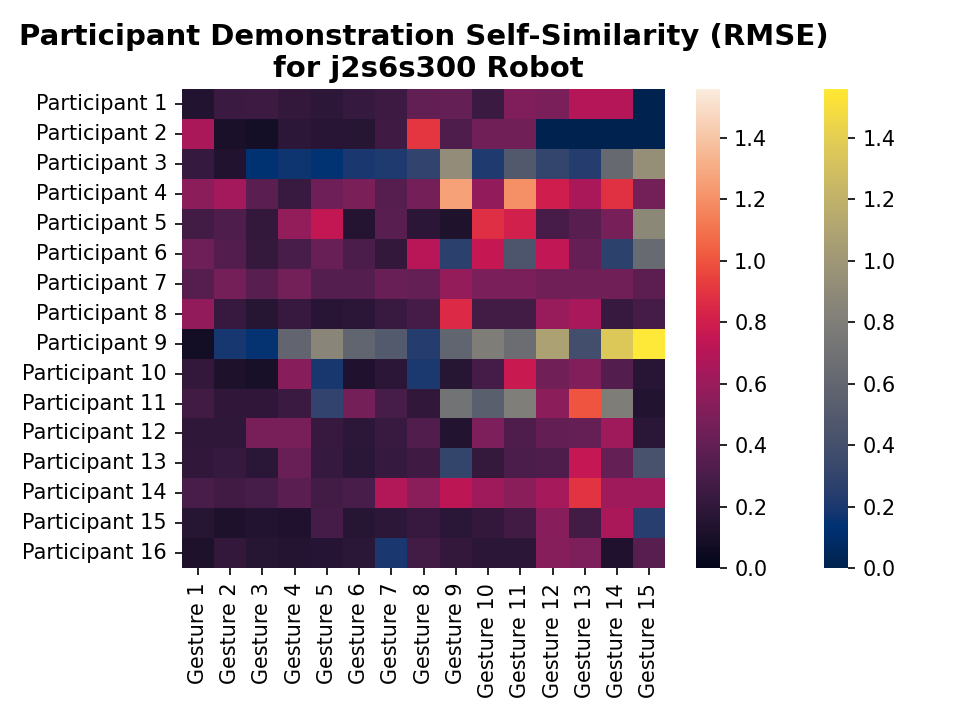

In [19]:
plt.close("all")

robot_name = "j2s6s300"
# robot_name = "Reachy"

followup = False
demo_max = 5

demo_heatmap_array, handed_array = generate_self_similarity_heat_map(robot_name,followup, demo_max)
plt.close("all")
plot_heatmap(robot_name, followup, demo_heatmap_array, handed_array, self=True)


In [3]:
"""Cross-correlation matrix:

Generate one cross-correlation graph per gesture, per robot, comparing all participants to each other.
Each participant does 5 demos, so that means 5x5 pairwise demo comparisons. Average the RMSE (should 
be legitimate; the lengths of the trajectories are almost the same). Each pairwise comparison of demos 
needs to be both temporally and spatially aligned. (Other analyses with only temporal or only spatial
alignment are also interesting, showing where participants chose similar motions with different rates
of speed, or similar motions but with different levels of enthusiasm. But for now, do all of it. The
order of operations is as follows:

1) For each robot and gesture, load two participants (go through all pairs)
2) For each pair, go through all pairs of demos
3) Figure out which hand is being used. Compare only the active hands. Make a matrix of which hand is
   being used so that we can color-code this in the final plot.
4) For that hand (for each participant), align the trajectories, first spatially (with evo), then 
   temporally (with DTW)
5) Compute the similarity between demos with APE (perhaps with translation scaling, or translation 
    only?)
6) Save this into the appropriate entry in a matrix so this can be turned into a heat map with seaborn
"""
# robot_name = "j2s6s300"
robot_name = "Reachy"
followup=False
demo_max = 5
gesture = 1
participant_1 = 12
participant_2 = 13

temp_metric, is_right_hand = generate_pairwise_comparison(participant_1, participant_2,robot_name, gesture, followup, demo_max, alignment=Alignment.Spatial)
# correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max)
# plot_heatmap(robot_name, followup, correlation_array, hand_array)                
print(temp_metric)
print(is_right_hand)


0.6823602273452946
True


Getting metrics for Participants 1 and 1: 
0.20206814410803722
Getting metrics for Participants 1 and 2: 
0.7016545843756137
Getting metrics for Participants 1 and 3: 
1.2916163098225788
Getting metrics for Participants 1 and 4: 
2.357344056769342
Getting metrics for Participants 1 and 5: 
1.0166433955883416
Getting metrics for Participants 1 and 6: 
1.3374600905468181
Getting metrics for Participants 1 and 7: 
2.37835609387978
Getting metrics for Participants 1 and 8: 
0.952724782770929
Getting metrics for Participants 1 and 9: 
1.0733234963051528
Getting metrics for Participants 1 and 10: 
2.2456073411359996
Getting metrics for Participants 1 and 11: 
1.4883321711553306
Getting metrics for Participants 1 and 12: 
0.9735053493099257
Getting metrics for Participants 1 and 13: 
2.3485756358742833
Getting metrics for Participants 1 and 14: 
2.214377982561129
Getting metrics for Participants 1 and 15: 
1.3418697415649405
Getting metrics for Participants 1 and 16: 
2.2035062711346183
Getti

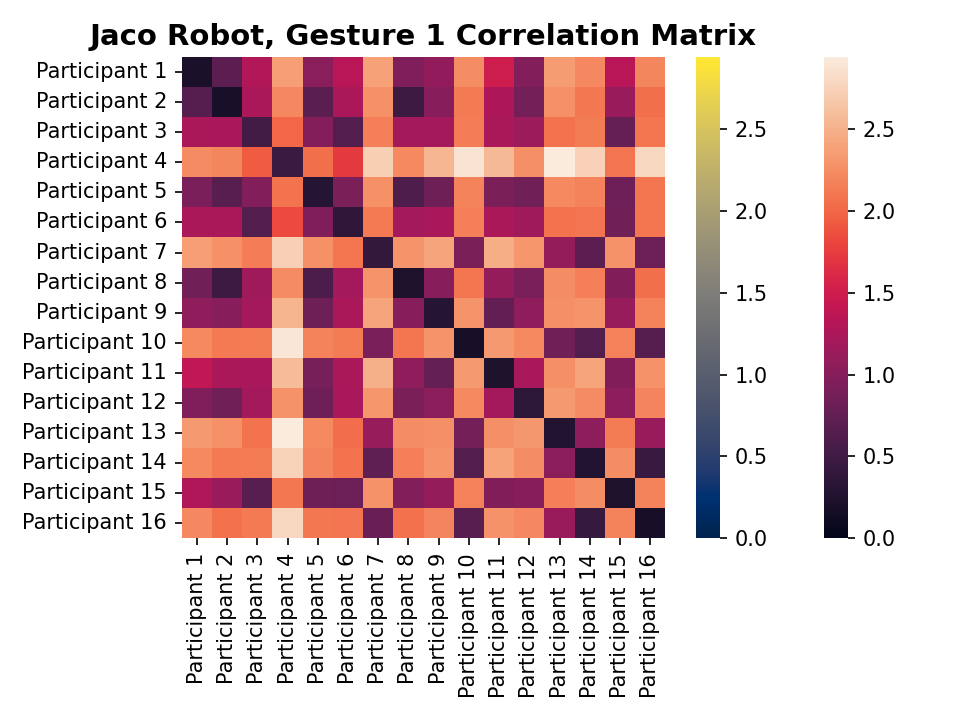

Getting metrics for Participants 1 and 1: 
0.3246377344875084
Getting metrics for Participants 1 and 2: 
0.6807528920354065
Getting metrics for Participants 1 and 3: 
1.0185306099579226
Getting metrics for Participants 1 and 4: 
2.2810185804612866
Getting metrics for Participants 1 and 5: 
1.0968727069137314
Getting metrics for Participants 1 and 6: 
1.2073794693351958
Getting metrics for Participants 1 and 7: 
2.4190749771329556
Getting metrics for Participants 1 and 8: 
0.828445091771433
Getting metrics for Participants 1 and 9: 
Gesture 2: Failed to get metrics for participant 1 demo 4, 9 demo 3.
 Retrying...
1.2528022774674445
Getting metrics for Participants 1 and 10: 
2.3467277288584714
Getting metrics for Participants 1 and 11: 
1.0441607346914532
Getting metrics for Participants 1 and 12: 
0.8541045465971887
Getting metrics for Participants 1 and 13: 
2.3805062250964952
Getting metrics for Participants 1 and 14: 
2.3593291991719383
Getting metrics for Participants 1 and 15: 
1.

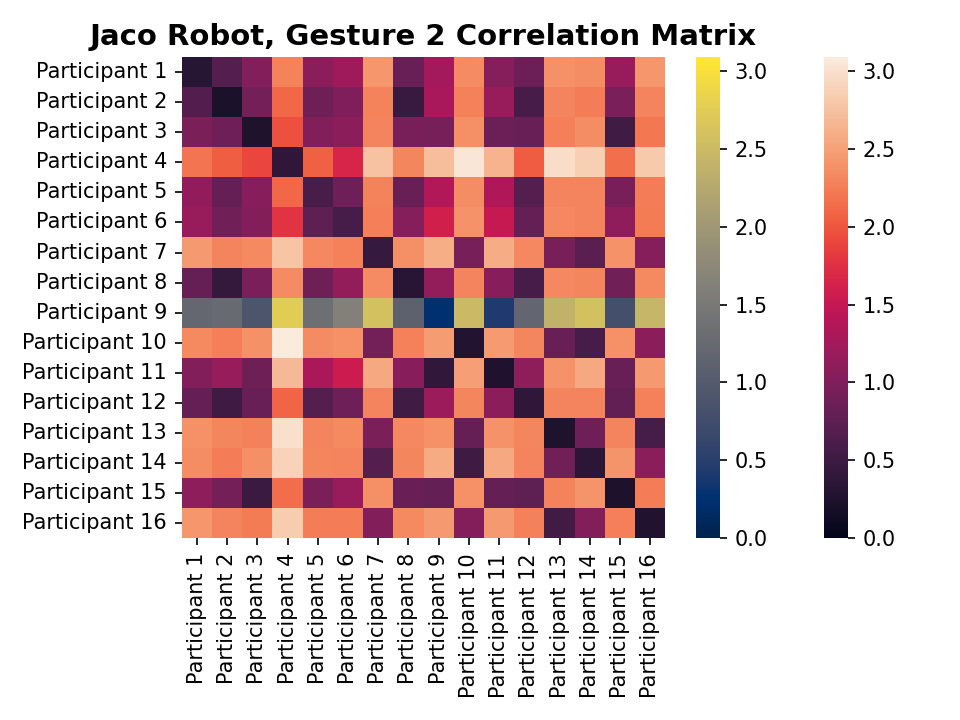

Getting metrics for Participants 1 and 1: 
0.3122973879578206
Getting metrics for Participants 1 and 2: 
0.5786229380641135
Getting metrics for Participants 1 and 3: 
1.1348378202849103
Getting metrics for Participants 1 and 4: 
2.3771546676821877
Getting metrics for Participants 1 and 5: 
1.0981903918939495
Getting metrics for Participants 1 and 6: 
1.2245653305930695
Getting metrics for Participants 1 and 7: 
2.426376365764045
Getting metrics for Participants 1 and 8: 
0.7643329641082005
Getting metrics for Participants 1 and 9: 
1.1768857687689125
Getting metrics for Participants 1 and 10: 
2.319429578525209
Getting metrics for Participants 1 and 11: 
1.0335137312103404
Getting metrics for Participants 1 and 12: 
0.9757862598938405
Getting metrics for Participants 1 and 13: 
2.3709411076492204
Getting metrics for Participants 1 and 14: 
2.379306186672165
Getting metrics for Participants 1 and 15: 
1.1712617371088008
Getting metrics for Participants 1 and 16: 
Gesture 3: Failed to ge

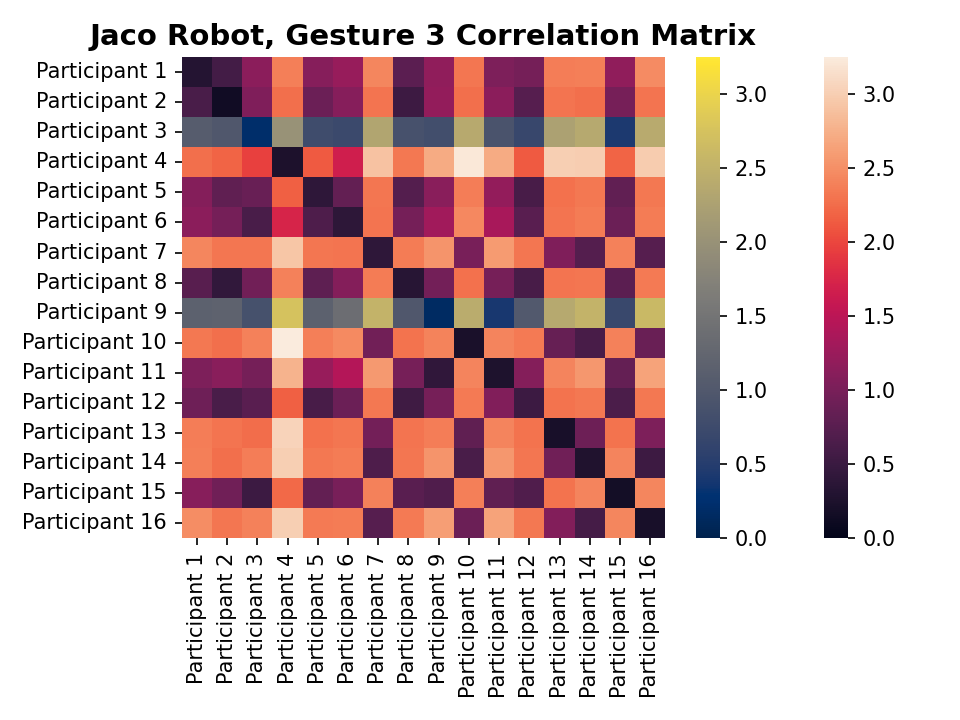

Getting metrics for Participants 1 and 1: 
0.5250297480881079
Getting metrics for Participants 1 and 2: 
0.7330408895144678
Getting metrics for Participants 1 and 3: 
0.9291568109096187
Getting metrics for Participants 1 and 4: 
Gesture 4: Failed to get metrics for participant 1 demo 5, 4 demo 2.
 Retrying...
2.463358841067928
Getting metrics for Participants 1 and 5: 
1.1911213398392615
Getting metrics for Participants 1 and 6: 
1.2818058535947612
Getting metrics for Participants 1 and 7: 
2.333916587924358
Getting metrics for Participants 1 and 8: 
Gesture 4: Failed to get metrics for participant 1 demo 4, 8 demo 4.
 Retrying...
0.9326958447907592
Getting metrics for Participants 1 and 9: 
1.929764564809341
Getting metrics for Participants 1 and 10: 
2.3408048822502194
Getting metrics for Participants 1 and 11: 
1.0668859586378352
Getting metrics for Participants 1 and 12: 
1.182102577784793
Getting metrics for Participants 1 and 13: 
2.377736193898844
Getting metrics for Participant

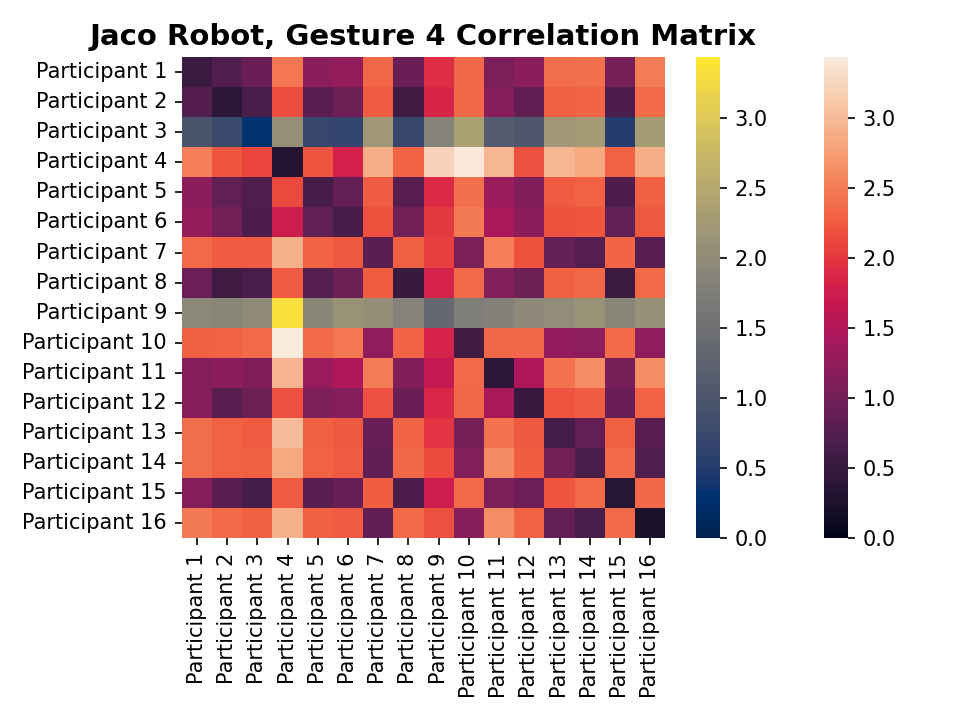

Getting metrics for Participants 1 and 1: 
0.3852858102113819
Getting metrics for Participants 1 and 2: 
Gesture 5: Failed to get metrics for participant 1 demo 1, 2 demo 1.
 Retrying...
0.6633451873732485
Getting metrics for Participants 1 and 3: 
0.7021498067725902
Getting metrics for Participants 1 and 4: 
2.4798609849364808
Getting metrics for Participants 1 and 5: 
1.127398422105262
Getting metrics for Participants 1 and 6: 
1.2325735330223406
Getting metrics for Participants 1 and 7: 
2.3670136686722016
Getting metrics for Participants 1 and 8: 
0.7709687698883871
Getting metrics for Participants 1 and 9: 
2.019341716551638
Getting metrics for Participants 1 and 10: 
1.0217377620196588
Getting metrics for Participants 1 and 11: 
1.8347981970773837
Getting metrics for Participants 1 and 12: 
0.9666228866636388
Getting metrics for Participants 1 and 13: 
2.324310366427889
Getting metrics for Participants 1 and 14: 
2.3531838389433926
Getting metrics for Participants 1 and 15: 
1.04

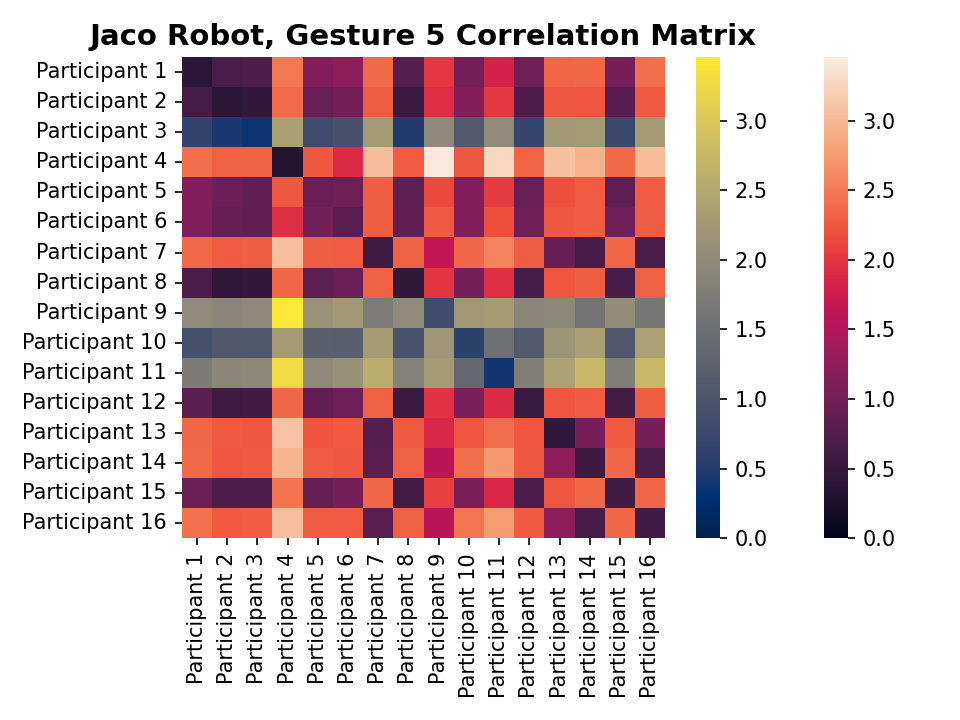

Getting metrics for Participants 1 and 1: 
Gesture 6: Failed to get metrics for participant 1 demo 5, 1 demo 3.
 Retrying...
0.3382350276498876
Getting metrics for Participants 1 and 2: 
0.6202148984909391
Getting metrics for Participants 1 and 3: 
0.8982172335927197
Getting metrics for Participants 1 and 4: 
2.5092916552947777
Getting metrics for Participants 1 and 5: 
1.1432465326906303
Getting metrics for Participants 1 and 6: 
1.3310459776785455
Getting metrics for Participants 1 and 7: 
2.3022049630516612
Getting metrics for Participants 1 and 8: 
0.692636447070183
Getting metrics for Participants 1 and 9: 
1.9989040127430255
Getting metrics for Participants 1 and 10: 
2.367070920753949
Getting metrics for Participants 1 and 11: 
1.363160301182876
Getting metrics for Participants 1 and 12: 
Gesture 6: Failed to get metrics for participant 1 demo 2, 12 demo 4.
 Retrying...
0.8716082359407362
Getting metrics for Participants 1 and 13: 
2.3716022855198187
Getting metrics for Particip

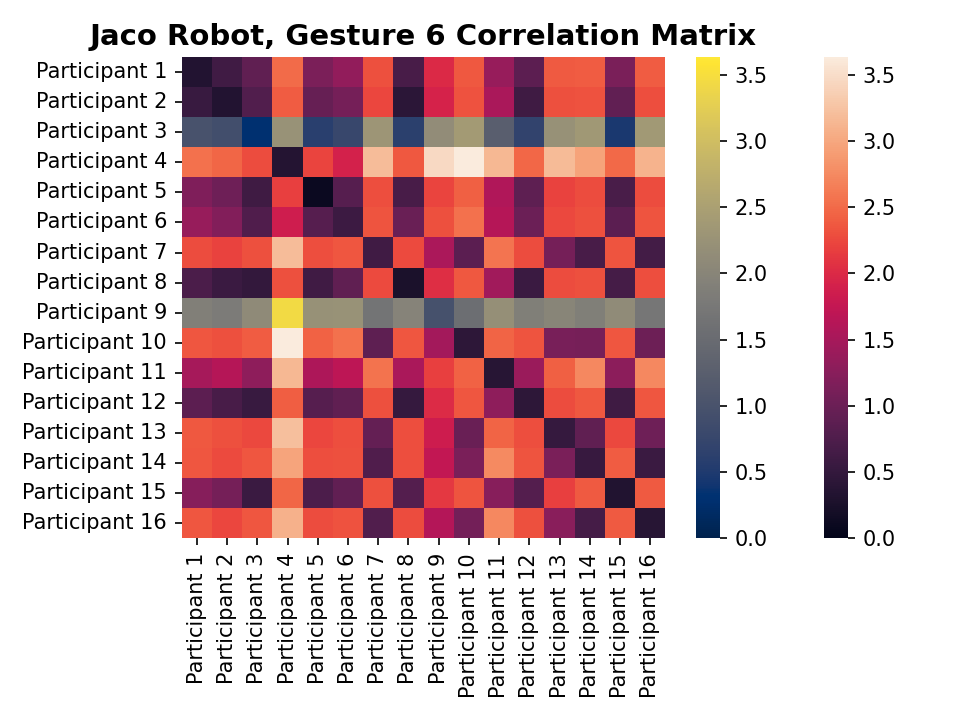

Getting metrics for Participants 1 and 1: 
0.4243988922501678
Getting metrics for Participants 1 and 2: 
0.7313892138397864
Getting metrics for Participants 1 and 3: 
0.6710146166125118
Getting metrics for Participants 1 and 4: 
2.449516449569153
Getting metrics for Participants 1 and 5: 
Gesture 7: Failed to get metrics for participant 1 demo 3, 5 demo 4.
 Retrying...
0.9024178918650695
Getting metrics for Participants 1 and 6: 
0.8970111816290146
Getting metrics for Participants 1 and 7: 
Gesture 7: Failed to get metrics for participant 1 demo 3, 7 demo 1.
 Retrying...
2.3955126072324457
Getting metrics for Participants 1 and 8: 
0.8326198127237829
Getting metrics for Participants 1 and 9: 
1.6294001101179605
Getting metrics for Participants 1 and 10: 
2.4812259168771713
Getting metrics for Participants 1 and 11: 
Gesture 7: Failed to get metrics for participant 1 demo 1, 11 demo 1.
 Retrying...
2.723824937526506
Getting metrics for Participants 1 and 12: 
0.9990784641133408
Getting 

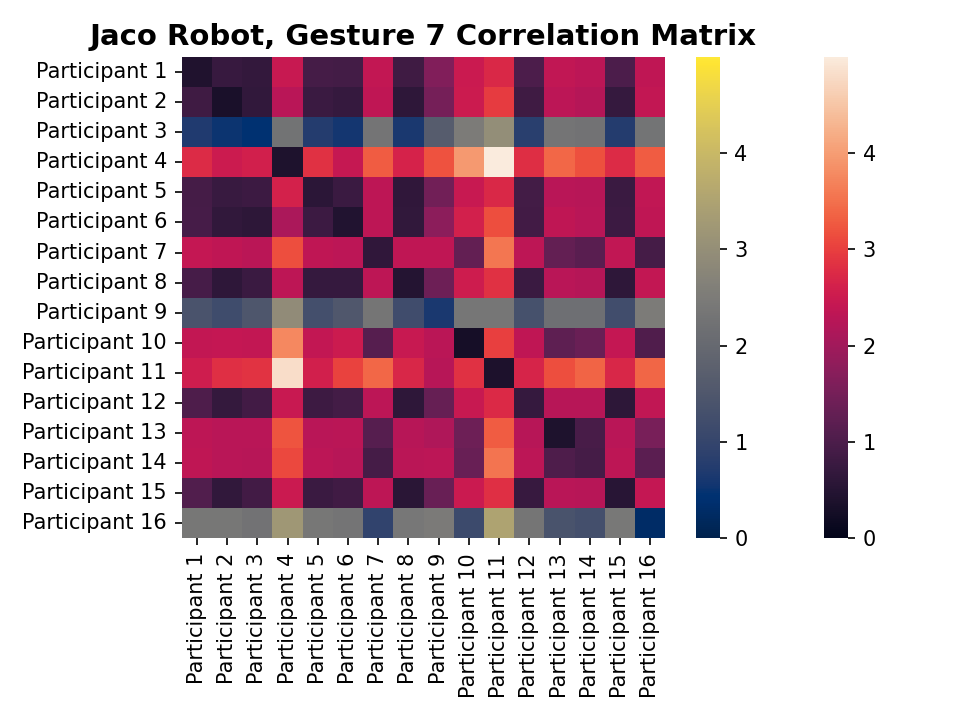

Getting metrics for Participants 1 and 1: 
0.4100347018934575
Getting metrics for Participants 1 and 2: 
0.8944938767985654
Getting metrics for Participants 1 and 3: 
1.120707674199102
Getting metrics for Participants 1 and 4: 
2.220694894842711
Getting metrics for Participants 1 and 5: 
1.205861180464364
Getting metrics for Participants 1 and 6: 
1.3144349490208784
Getting metrics for Participants 1 and 7: 
2.373945638050658
Getting metrics for Participants 1 and 8: 
0.9919354407392942
Getting metrics for Participants 1 and 9: 
1.5546344814207356
Getting metrics for Participants 1 and 10: 
1.2596539410819771
Getting metrics for Participants 1 and 11: 
3.1539230488221532
Getting metrics for Participants 1 and 12: 
1.2154759456805673
Getting metrics for Participants 1 and 13: 
2.3913988168729823
Getting metrics for Participants 1 and 14: 
2.3203477233354857
Getting metrics for Participants 1 and 15: 
1.2529901467003617
Getting metrics for Participants 1 and 16: 
2.329788588412413
Gettin

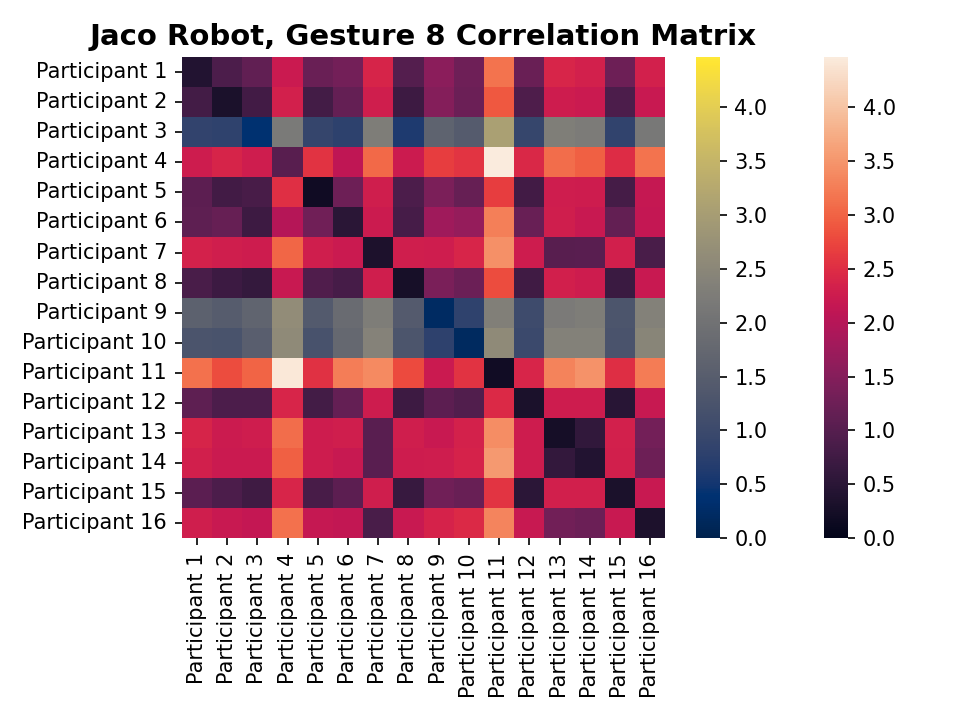

Getting metrics for Participants 1 and 1: 
0.3517010680575022
Getting metrics for Participants 1 and 2: 
0.7892758973585479
Getting metrics for Participants 1 and 3: 
0.9463606015867776
Getting metrics for Participants 1 and 4: 
1.078547328931165
Getting metrics for Participants 1 and 5: 
1.3776514047379238
Getting metrics for Participants 1 and 6: 
2.3543286906825713
Getting metrics for Participants 1 and 7: 
2.3714240474812165
Getting metrics for Participants 1 and 8: 
0.8670969358429665
Getting metrics for Participants 1 and 9: 
1.2449392510617596
Getting metrics for Participants 1 and 10: 
Gesture 9: Failed to get metrics for participant 1 demo 1, 10 demo 1.
 Retrying...
2.3766870142082257
Getting metrics for Participants 1 and 11: 
1.8183908559559356
Getting metrics for Participants 1 and 12: 
1.2847432088977135
Getting metrics for Participants 1 and 13: 
2.1493642128437975
Getting metrics for Participants 1 and 14: 
2.3075431581092913
Getting metrics for Participants 1 and 15: 
1

In [4]:
%matplotlib widget
robot_name = "Reachy"
followup=False
demo_max = 5
alignment = Alignment.SpatioTemporal

for gesture in (2,5):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

# robot_name = "j2s6s300"
# for gesture in range(11,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

# alignment = Alignment.Spatial
# robot_name = "Reachy"
# for gesture in range(1,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

# robot_name = "j2s6s300"
# for gesture in range(1,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

# alignment = Alignment.Temporal
# robot_name = "Reachy"
# for gesture in range(1,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

# robot_name = "j2s6s300"
# for gesture in range(1,16):    
#     plt.close("all")
#     correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
#     np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
#     filename = str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation_"+str(alignment)+".npz"
#     data = np.load(filename)
#     correlation_array = data['correlation_array']
#     hand_array = data['hand_array']
#     plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)


In [ ]:
## Comparison between RH and robot end-eff
# (We'll want comparisons between the person's different demos, and the end-eff and the lh, also)

# robot_name='j2s6s300'
robot_name='Reachy'

followup = False

if followup:
    PID_max = 9
    gesture_max = 6
else: 
    PID_max = 16
    gesture_max = 15

for singlePIDval in range(1,PID_max+1):
    for gesture_num in range(1,gesture_max+1):
        end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)

        demo_max=5
        end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
        # for i in range(0,5):
        #     plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

        for demo_num in range(0,5):
            end_eff_traj = get_evo_trajectory(end_eff[i])
            right_hand_traj = get_evo_trajectory(rh[i])   

            end_eff_traj, right_hand_traj = evo_sync(end_eff_traj, right_hand_traj)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            print(metric.get_all_statistics()) # Not aligned statistics
            
            right_hand_traj = align(right_hand_traj, end_eff_traj)

            end_eff_aligned = convert_evo_to_np(end_eff_traj, end_eff[i].shape)
            # print(end_eff_aligned.shape)
            
            rh_aligned = convert_evo_to_np(right_hand_traj, rh[i].shape)
            # print(rh_aligned.shape)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            metric.get_all_statistics() #Aligned statistics

In [ ]:
## Batch heatmap processing for follow-up study
%matplotlib widget
robot_name = "Reachy"
followup=True
demo_max = 5
alignment = Alignment.SpatioTemporal

PID_max, gesture_max = study_range_vals(followup)

for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

alignment = Alignment.Spatial
robot_name = "Reachy"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

alignment = Alignment.Temporal
robot_name = "Reachy"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)

robot_name = "j2s6s300"
for gesture in range(1,gesture_max+1):    
    plt.close("all")
    correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max,alignment=alignment)
    np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment),correlation_array=correlation_array, hand_array=hand_array)
    filename = str(robot_name)+"_gesture_"+str(gesture)+"_followup_cross_correlation_"+str(alignment)+".npz"
    data = np.load(filename)
    correlation_array = data['correlation_array']
    hand_array = data['hand_array']
    plot_correlation_matrix(robot_name, gesture, followup, alignment, correlation_array, hand_array)


In [ ]:
## Batch Matrix Generation for similarity between hand and end-eff
%matplotlib widget
robot_name = "Reachy"
followup=False
demo_max = 5
alignment = Alignment.SpatioTemporal

heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Spatial
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Temporal
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)


robot_name = "j2s6s300"
alignment = Alignment.SpatioTemporal
plt.close("all")
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Spatial
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)

plt.close("all")
alignment = Alignment.Temporal
heat_map, hand_array = generate_hand_endeff_similarity_matrix(robot_name, followup, demo_max, alignment=alignment)
np.savez(str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment),heat_map=heat_map, hand_array=hand_array)
filename = str(robot_name)+"_eeff_hand_similarity_matrix_"+str(alignment)+".npz"
data = np.load(filename)
heat_map = data['heat_map']
hand_array = data['hand_array']
plot_heatmap(robot_name, followup, heat_map, hand_array, alignment=alignment)
